# Importing Libraries

In [20]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import supervision as sv
import itertools
from tqdm import tqdm

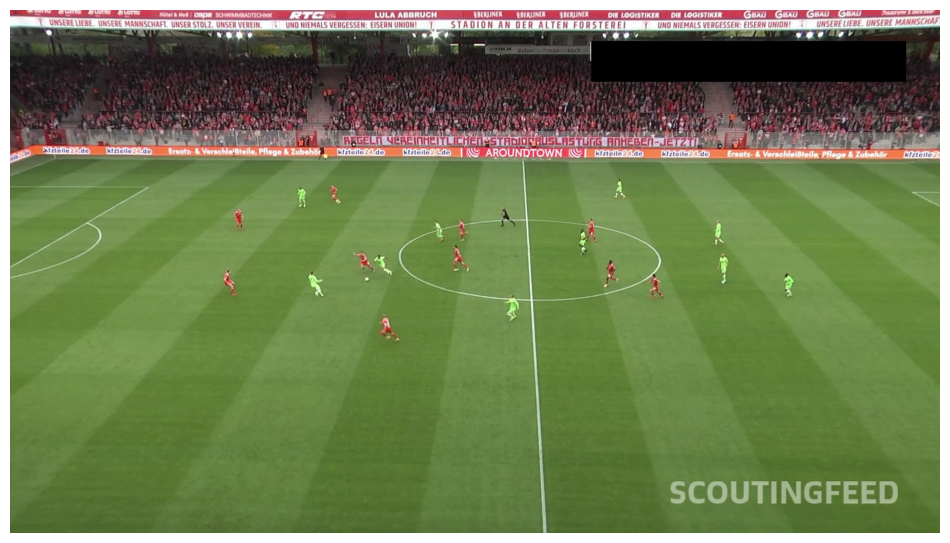

In [9]:
video_path='dataset/test/121364_0.mp4'

frame_index = 100 
frame_generator = sv.get_video_frames_generator(video_path)
frame = next(itertools.islice(frame_generator,frame_index,None))


sv.plot_image(frame)


0: 736x1280 20 players, 2 referees, 8.9ms
Speed: 6.8ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


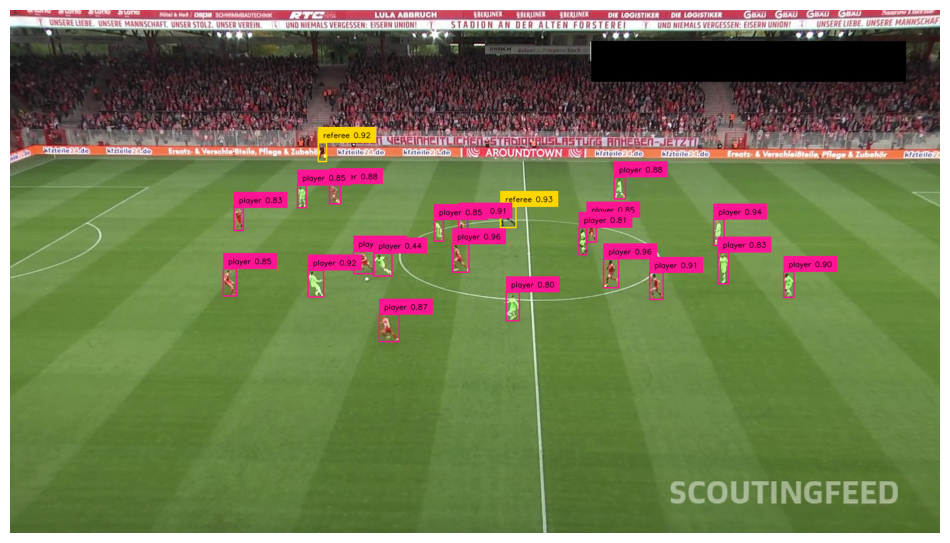

In [11]:
box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000')
)


model=YOLO('runs/detect/train/weights/best.pt')

result=model(frame,conf=0.3)[0]
detections = sv.Detections.from_ultralytics(result)


labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections['class_name'], detections.confidence)
]

annotated_frame = frame.copy()

annotated_frame = box_annotator.annotate(scene=annotated_frame,detections=detections)
annotated_frame = label_annotator.annotate(scene=annotated_frame,detections=detections,labels=labels)

sv.plot_image(annotated_frame)


# A better visualization


0: 736x1280 20 players, 2 referees, 14.7ms
Speed: 10.5ms preprocess, 14.7ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


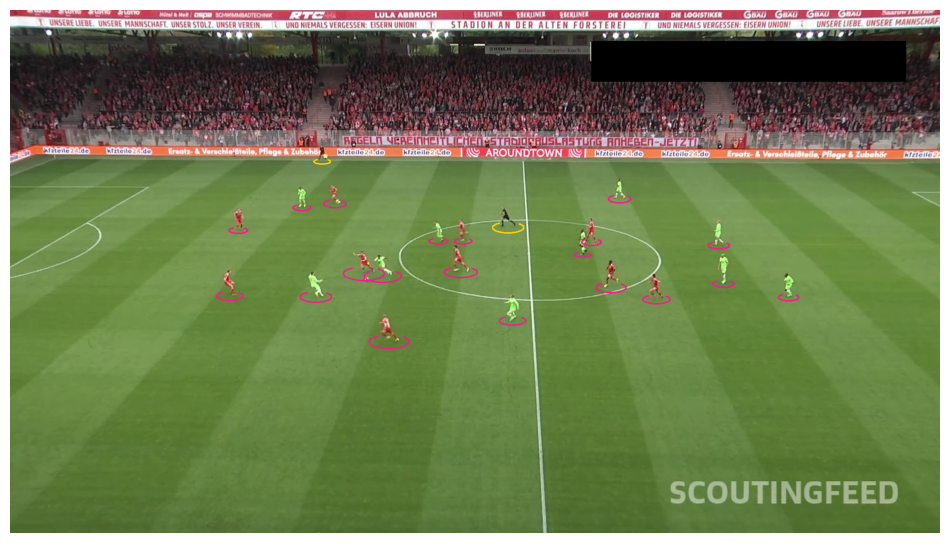

In [12]:
ball_id = 0

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)


label_annotator=sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex("#000000"),
    text_position=sv.Position.BOTTOM_CENTER

)

triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

tracker=sv.ByteTrack()
tracker.reset()


result = model(frame, conf=0.3)[0]
detections = sv.Detections.from_ultralytics(result)

ball_detections = detections[detections.class_id == ball_id]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != ball_id]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections.class_id -= 1
all_detections=tracker.update_with_detections(all_detections)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)
annotated_frame= label_annotator.annotate(scene=annotated_frame,detections=all_detections,labels=labels)

sv.plot_image(annotated_frame)

In [13]:
source_video_path='dataset/test/121364_0.mp4'
target_video_path= 'dataset/test/121364_0_result_1.mp4'


video_info=sv.VideoInfo.from_video_path(source_video_path)
print(video_info)

VideoInfo(width=1920, height=1080, fps=25, total_frames=750)


In [26]:
ball_id = 0

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)

label_annotator=sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex("#000000"),
    text_position=sv.Position.BOTTOM_CENTER

)

triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
)

tracker=sv.ByteTrack()
tracker.reset()

video_sink=sv.VideoSink(target_video_path,video_info=video_info)
frame_generator=sv.get_video_frames_generator(source_video_path)

with video_sink:
    for frame in tqdm(frame_generator,total=video_info.total_frames,position=0):
        
        result = model(frame, conf=0.3)[0]
        detections = sv.Detections.from_ultralytics(result)
        
        ball_detections = detections[detections.class_id == ball_id]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
        
        all_detections = detections[detections.class_id != ball_id]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections.class_id -= 1
        all_detections=tracker.update_with_detections(all_detections)

        labels = [
            f"#{tracker_id}"
            for tracker_id
            in all_detections.tracker_id
        ]
        
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(scene=annotated_frame,detections=all_detections)
        annotated_frame = triangle_annotator.annotate(scene=annotated_frame,detections=ball_detections)
        annotated_frame= label_annotator.annotate(scene=annotated_frame,detections=all_detections,labels=labels)
        
        video_sink.write_frame(annotated_frame)

  0%|                                                                                                                    | 0/750 [00:00<?, ?it/s]


0: 736x1280 1 goalkeeper, 22 players, 2 referees, 18.9ms
Speed: 9.3ms preprocess, 18.9ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


  0%|▏                                                                                                           | 1/750 [00:00<01:53,  6.58it/s]


0: 736x1280 1 goalkeeper, 22 players, 2 referees, 12.8ms
Speed: 8.8ms preprocess, 12.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 12.8ms
Speed: 8.9ms preprocess, 12.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


  0%|▍                                                                                                           | 3/750 [00:00<01:07, 11.04it/s]


0: 736x1280 1 goalkeeper, 23 players, 2 referees, 13.1ms
Speed: 8.9ms preprocess, 13.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 23 players, 2 referees, 13.0ms
Speed: 8.9ms preprocess, 13.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


  1%|▋                                                                                                           | 5/750 [00:00<00:58, 12.75it/s]


0: 736x1280 1 goalkeeper, 21 players, 2 referees, 13.0ms
Speed: 8.9ms preprocess, 13.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 22 players, 2 referees, 10.2ms
Speed: 7.2ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


  1%|█                                                                                                           | 7/750 [00:00<00:52, 14.24it/s]


0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 9.5ms
Speed: 6.7ms preprocess, 9.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.5ms
Speed: 6.5ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


  1%|█▎                                                                                                          | 9/750 [00:00<00:46, 15.97it/s]


0: 736x1280 1 goalkeeper, 20 players, 1 referee, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 9.1ms
Speed: 6.4ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


  2%|█▋                                                                                                         | 12/750 [00:00<00:41, 17.66it/s]


0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 22 players, 2 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


  2%|█▉                                                                                                         | 14/750 [00:00<00:42, 17.43it/s]


0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


  2%|██▎                                                                                                        | 16/750 [00:01<00:40, 18.11it/s]


0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 1 referee, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


  3%|██▋                                                                                                        | 19/750 [00:01<00:38, 18.90it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


  3%|███▏                                                                                                       | 22/750 [00:01<00:37, 19.39it/s]


0: 736x1280 1 ball, 1 goalkeeper, 22 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


  3%|███▌                                                                                                       | 25/750 [00:01<00:36, 19.63it/s]


0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.3ms
Speed: 6.4ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


  4%|███▉                                                                                                       | 28/750 [00:01<00:36, 19.86it/s]


0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.5ms
Speed: 6.4ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


  4%|████▍                                                                                                      | 31/750 [00:01<00:35, 20.00it/s]


0: 736x1280 1 goalkeeper, 21 players, 2 referees, 11.6ms
Speed: 6.3ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.4ms
Speed: 6.5ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


  4%|████▋                                                                                                      | 33/750 [00:01<00:36, 19.83it/s]


0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.4ms
Speed: 6.5ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.5ms
Speed: 6.5ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


  5%|████▉                                                                                                      | 35/750 [00:01<00:36, 19.75it/s]


0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


  5%|█████▎                                                                                                     | 37/750 [00:02<00:36, 19.80it/s]


0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


  5%|█████▌                                                                                                     | 39/750 [00:02<00:35, 19.84it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.4ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


  5%|█████▊                                                                                                     | 41/750 [00:02<00:35, 19.85it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


  6%|██████▏                                                                                                    | 43/750 [00:02<00:35, 19.83it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


  6%|██████▍                                                                                                    | 45/750 [00:02<00:35, 19.82it/s]


0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


  6%|██████▊                                                                                                    | 48/750 [00:02<00:35, 19.94it/s]


0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 22 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


  7%|███████▎                                                                                                   | 51/750 [00:02<00:35, 19.96it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.7ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.9ms
Speed: 6.7ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


  7%|███████▋                                                                                                   | 54/750 [00:02<00:34, 20.15it/s]


0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 8.9ms
Speed: 6.8ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 9.3ms
Speed: 6.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


  8%|████████▏                                                                                                  | 57/750 [00:03<00:34, 20.18it/s]


0: 736x1280 1 ball, 1 goalkeeper, 22 players, 2 referees, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


  8%|████████▌                                                                                                  | 60/750 [00:03<00:34, 20.15it/s]


0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


  8%|████████▉                                                                                                  | 63/750 [00:03<00:34, 20.20it/s]


0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 1 referee, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


  9%|█████████▍                                                                                                 | 66/750 [00:03<00:33, 20.25it/s]


0: 736x1280 1 goalkeeper, 21 players, 1 referee, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 1 referee, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 22 players, 1 referee, 9.4ms
Speed: 6.6ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


  9%|█████████▊                                                                                                 | 69/750 [00:03<00:33, 20.23it/s]


0: 736x1280 21 players, 1 referee, 9.5ms
Speed: 6.8ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 1 referee, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 24 players, 2 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 10%|██████████▎                                                                                                | 72/750 [00:03<00:33, 20.38it/s]


0: 736x1280 22 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 24 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 10%|██████████▋                                                                                                | 75/750 [00:03<00:33, 20.44it/s]


0: 736x1280 21 players, 2 referees, 8.9ms
Speed: 6.7ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 23 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 10%|███████████▏                                                                                               | 78/750 [00:04<00:32, 20.47it/s]


0: 736x1280 22 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 22 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 11%|███████████▌                                                                                               | 81/750 [00:04<00:32, 20.49it/s]


0: 736x1280 23 players, 2 referees, 9.0ms
Speed: 6.7ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 8.9ms
Speed: 6.7ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 11%|███████████▉                                                                                               | 84/750 [00:04<00:32, 20.44it/s]


0: 736x1280 21 players, 2 referees, 9.4ms
Speed: 6.6ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 10.7ms
Speed: 8.4ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 12%|████████████▍                                                                                              | 87/750 [00:04<00:32, 20.11it/s]


0: 736x1280 22 players, 2 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 9.0ms
Speed: 6.4ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 22 players, 2 referees, 9.5ms
Speed: 6.4ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 12%|████████████▊                                                                                              | 90/750 [00:04<00:32, 20.06it/s]


0: 736x1280 20 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 12%|█████████████▎                                                                                             | 93/750 [00:04<00:32, 20.16it/s]


0: 736x1280 22 players, 2 referees, 9.0ms
Speed: 6.7ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 9.4ms
Speed: 6.5ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 13%|█████████████▋                                                                                             | 96/750 [00:04<00:32, 20.14it/s]


0: 736x1280 21 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 9.5ms
Speed: 6.4ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 13%|██████████████                                                                                             | 99/750 [00:05<00:32, 20.28it/s]


0: 736x1280 20 players, 3 referees, 9.1ms
Speed: 6.7ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 9.0ms
Speed: 6.7ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 14%|██████████████▍                                                                                           | 102/750 [00:05<00:31, 20.40it/s]


0: 736x1280 21 players, 2 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 14%|██████████████▊                                                                                           | 105/750 [00:05<00:31, 20.39it/s]


0: 736x1280 20 players, 2 referees, 9.4ms
Speed: 6.8ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 9.1ms
Speed: 6.7ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 14%|███████████████▎                                                                                          | 108/750 [00:05<00:31, 20.40it/s]


0: 736x1280 20 players, 2 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 15%|███████████████▋                                                                                          | 111/750 [00:05<00:31, 20.40it/s]


0: 736x1280 21 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 15%|████████████████                                                                                          | 114/750 [00:05<00:31, 20.37it/s]


0: 736x1280 23 players, 2 referees, 9.3ms
Speed: 6.8ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 3 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 3 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 16%|████████████████▌                                                                                         | 117/750 [00:06<00:31, 20.36it/s]


0: 736x1280 21 players, 4 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 3 referees, 9.3ms
Speed: 6.7ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 16%|████████████████▉                                                                                         | 120/750 [00:06<00:31, 20.31it/s]


0: 736x1280 22 players, 2 referees, 9.3ms
Speed: 6.7ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 9.1ms
Speed: 6.7ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 24 players, 2 referees, 9.0ms
Speed: 6.7ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 16%|█████████████████▍                                                                                        | 123/750 [00:06<00:30, 20.27it/s]


0: 736x1280 21 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 17%|█████████████████▊                                                                                        | 126/750 [00:06<00:30, 20.28it/s]


0: 736x1280 21 players, 2 referees, 9.1ms
Speed: 6.8ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 8.9ms
Speed: 6.7ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 17%|██████████████████▏                                                                                       | 129/750 [00:06<00:30, 20.31it/s]


0: 736x1280 20 players, 2 referees, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 22 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 18%|██████████████████▋                                                                                       | 132/750 [00:06<00:30, 20.23it/s]


0: 736x1280 20 players, 2 referees, 9.6ms
Speed: 6.9ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 21 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 24 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 18%|███████████████████                                                                                       | 135/750 [00:06<00:30, 20.22it/s]


0: 736x1280 2 balls, 21 players, 2 referees, 9.0ms
Speed: 6.7ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 20 players, 2 referees, 9.0ms
Speed: 6.7ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 20 players, 1 referee, 9.3ms
Speed: 6.7ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 18%|███████████████████▌                                                                                      | 138/750 [00:07<00:30, 20.22it/s]


0: 736x1280 1 ball, 24 players, 1 referee, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 21 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 22 players, 2 referees, 9.4ms
Speed: 6.8ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 19%|███████████████████▉                                                                                      | 141/750 [00:07<00:30, 20.20it/s]


0: 736x1280 1 ball, 20 players, 2 referees, 9.1ms
Speed: 7.5ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 22 players, 1 referee, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 22 players, 1 referee, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 19%|████████████████████▎                                                                                     | 144/750 [00:07<00:29, 20.21it/s]


0: 736x1280 1 ball, 20 players, 1 referee, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 23 players, 1 referee, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 23 players, 1 referee, 9.0ms
Speed: 6.7ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 20%|████████████████████▊                                                                                     | 147/750 [00:07<00:29, 20.36it/s]


0: 736x1280 1 ball, 22 players, 1 referee, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 23 players, 1 referee, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 23 players, 2 referees, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 20%|█████████████████████▏                                                                                    | 150/750 [00:07<00:29, 20.33it/s]


0: 736x1280 1 ball, 21 players, 2 referees, 9.3ms
Speed: 6.8ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 21 players, 2 referees, 9.1ms
Speed: 6.7ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 23 players, 2 referees, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 20%|█████████████████████▌                                                                                    | 153/750 [00:07<00:29, 20.31it/s]


0: 736x1280 2 balls, 22 players, 2 referees, 9.3ms
Speed: 6.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 21 players, 2 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 21 players, 2 referees, 8.9ms
Speed: 6.8ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 21%|██████████████████████                                                                                    | 156/750 [00:07<00:29, 20.33it/s]


0: 736x1280 22 players, 3 referees, 8.8ms
Speed: 6.9ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 9.6ms
Speed: 6.7ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 21%|██████████████████████▍                                                                                   | 159/750 [00:08<00:29, 20.25it/s]


0: 736x1280 1 ball, 20 players, 2 referees, 9.1ms
Speed: 6.7ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 3 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 21 players, 2 referees, 9.1ms
Speed: 6.7ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 22%|██████████████████████▉                                                                                   | 162/750 [00:08<00:28, 20.31it/s]


0: 736x1280 1 ball, 21 players, 2 referees, 8.8ms
Speed: 6.8ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 21 players, 2 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 2 balls, 21 players, 2 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 22%|███████████████████████▎                                                                                  | 165/750 [00:08<00:28, 20.41it/s]


0: 736x1280 2 balls, 21 players, 2 referees, 9.1ms
Speed: 6.7ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 2 balls, 20 players, 3 referees, 8.9ms
Speed: 6.7ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 20 players, 3 referees, 9.1ms
Speed: 6.7ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 22%|███████████████████████▋                                                                                  | 168/750 [00:08<00:28, 20.36it/s]


0: 736x1280 1 ball, 21 players, 3 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 21 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 21 players, 2 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 23%|████████████████████████▏                                                                                 | 171/750 [00:08<00:28, 20.30it/s]


0: 736x1280 19 players, 2 referees, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 20 players, 2 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 9.0ms
Speed: 6.7ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 23%|████████████████████████▌                                                                                 | 174/750 [00:08<00:28, 20.43it/s]


0: 736x1280 21 players, 2 referees, 9.0ms
Speed: 6.8ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 8.9ms
Speed: 6.8ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 24%|█████████████████████████                                                                                 | 177/750 [00:08<00:28, 20.34it/s]


0: 736x1280 20 players, 2 referees, 9.0ms
Speed: 6.7ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 9.3ms
Speed: 6.7ms preprocess, 9.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 9.3ms
Speed: 6.7ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 24%|█████████████████████████▍                                                                                | 180/750 [00:09<00:27, 20.44it/s]


0: 736x1280 21 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 22 players, 2 referees, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 24%|█████████████████████████▊                                                                                | 183/750 [00:09<00:27, 20.50it/s]


0: 736x1280 20 players, 2 referees, 9.3ms
Speed: 6.7ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 22 players, 2 referees, 9.1ms
Speed: 6.7ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 25%|██████████████████████████▎                                                                               | 186/750 [00:09<00:27, 20.47it/s]


0: 736x1280 20 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 19 players, 2 referees, 9.0ms
Speed: 6.7ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 19 players, 3 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 25%|██████████████████████████▋                                                                               | 189/750 [00:09<00:27, 20.45it/s]


0: 736x1280 1 ball, 20 players, 2 referees, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 22 players, 2 referees, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 23 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 26%|███████████████████████████▏                                                                              | 192/750 [00:09<00:27, 20.39it/s]


0: 736x1280 21 players, 2 referees, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 9.1ms
Speed: 6.8ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 19 players, 2 referees, 9.1ms
Speed: 6.7ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 26%|███████████████████████████▌                                                                              | 195/750 [00:09<00:27, 20.29it/s]


0: 736x1280 1 ball, 19 players, 2 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 19 players, 2 referees, 9.1ms
Speed: 6.7ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 20 players, 2 referees, 9.1ms
Speed: 6.7ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 26%|███████████████████████████▉                                                                              | 198/750 [00:09<00:27, 20.36it/s]


0: 736x1280 1 ball, 20 players, 2 referees, 9.3ms
Speed: 6.8ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 20 players, 2 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 19 players, 2 referees, 9.5ms
Speed: 6.6ms preprocess, 9.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 27%|████████████████████████████▍                                                                             | 201/750 [00:10<00:26, 20.47it/s]


0: 736x1280 2 balls, 20 players, 2 referees, 9.1ms
Speed: 6.7ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 2 balls, 21 players, 2 referees, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 20 players, 2 referees, 9.2ms
Speed: 7.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 27%|████████████████████████████▊                                                                             | 204/750 [00:10<00:26, 20.36it/s]


0: 736x1280 21 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 22 players, 2 referees, 9.0ms
Speed: 6.4ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 19 players, 3 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 28%|█████████████████████████████▎                                                                            | 207/750 [00:10<00:26, 20.33it/s]


0: 736x1280 1 ball, 20 players, 2 referees, 10.7ms
Speed: 8.1ms preprocess, 10.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 23 players, 2 referees, 9.5ms
Speed: 6.6ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 19 players, 2 referees, 9.4ms
Speed: 6.5ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 28%|█████████████████████████████▋                                                                            | 210/750 [00:10<00:27, 19.99it/s]


0: 736x1280 2 balls, 20 players, 2 referees, 9.5ms
Speed: 6.4ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 18 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 19 players, 2 referees, 9.5ms
Speed: 6.6ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 28%|██████████████████████████████                                                                            | 213/750 [00:10<00:26, 20.00it/s]


0: 736x1280 19 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 18 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 18 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 29%|██████████████████████████████▌                                                                           | 216/750 [00:10<00:26, 20.20it/s]


0: 736x1280 1 ball, 18 players, 2 referees, 9.5ms
Speed: 6.6ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 9.0ms
Speed: 7.0ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 19 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 29%|██████████████████████████████▉                                                                           | 219/750 [00:11<00:26, 20.24it/s]


0: 736x1280 20 players, 2 referees, 9.4ms
Speed: 6.7ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 22 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 30%|███████████████████████████████▍                                                                          | 222/750 [00:11<00:26, 20.27it/s]


0: 736x1280 1 ball, 19 players, 2 referees, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 20 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 19 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 30%|███████████████████████████████▊                                                                          | 225/750 [00:11<00:25, 20.31it/s]


0: 736x1280 1 ball, 19 players, 3 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 21 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 19 players, 2 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 30%|████████████████████████████████▏                                                                         | 228/750 [00:11<00:25, 20.37it/s]


0: 736x1280 19 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 19 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 20 players, 3 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 31%|████████████████████████████████▋                                                                         | 231/750 [00:11<00:25, 20.36it/s]


0: 736x1280 1 ball, 21 players, 3 referees, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 20 players, 3 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 20 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 31%|█████████████████████████████████                                                                         | 234/750 [00:11<00:25, 20.38it/s]


0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 32%|█████████████████████████████████▍                                                                        | 237/750 [00:11<00:25, 20.37it/s]


0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 32%|█████████████████████████████████▉                                                                        | 240/750 [00:12<00:25, 20.30it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.5ms
Speed: 6.6ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 9.1ms
Speed: 6.9ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 32%|██████████████████████████████████▎                                                                       | 243/750 [00:12<00:25, 20.26it/s]


0: 736x1280 1 goalkeeper, 20 players, 1 referee, 9.1ms
Speed: 6.4ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 33%|██████████████████████████████████▊                                                                       | 246/750 [00:12<00:24, 20.25it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.5ms
Speed: 6.3ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 33%|███████████████████████████████████▏                                                                      | 249/750 [00:12<00:24, 20.20it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 34%|███████████████████████████████████▌                                                                      | 252/750 [00:12<00:24, 20.21it/s]


0: 736x1280 1 goalkeeper, 19 players, 1 referee, 9.0ms
Speed: 6.7ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 1 referee, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 9.3ms
Speed: 6.4ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 34%|████████████████████████████████████                                                                      | 255/750 [00:12<00:24, 20.23it/s]


0: 736x1280 1 goalkeeper, 20 players, 3 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 34%|████████████████████████████████████▍                                                                     | 258/750 [00:12<00:24, 20.16it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.7ms
Speed: 6.7ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 35%|████████████████████████████████████▉                                                                     | 261/750 [00:13<00:24, 20.10it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.4ms
Speed: 6.5ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 35%|█████████████████████████████████████▎                                                                    | 264/750 [00:13<00:24, 20.19it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.3ms
Speed: 6.4ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 36%|█████████████████████████████████████▋                                                                    | 267/750 [00:13<00:24, 20.07it/s]


0: 736x1280 1 goalkeeper, 20 players, 3 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.4ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 36%|██████████████████████████████████████▏                                                                   | 270/750 [00:13<00:23, 20.08it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 36%|██████████████████████████████████████▌                                                                   | 273/750 [00:13<00:23, 20.11it/s]


0: 736x1280 1 goalkeeper, 21 players, 2 referees, 10.1ms
Speed: 6.7ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 9.2ms
Speed: 6.3ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 37%|███████████████████████████████████████                                                                   | 276/750 [00:13<00:23, 20.05it/s]


0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.2ms
Speed: 6.3ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 37%|███████████████████████████████████████▍                                                                  | 279/750 [00:13<00:23, 20.09it/s]


0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.4ms
Speed: 6.7ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.3ms
Speed: 6.4ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 38%|███████████████████████████████████████▊                                                                  | 282/750 [00:14<00:23, 20.04it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.4ms
Speed: 6.3ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 38%|████████████████████████████████████████▎                                                                 | 285/750 [00:14<00:23, 20.04it/s]


0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 9.4ms
Speed: 6.9ms preprocess, 9.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.8ms
Speed: 6.4ms preprocess, 8.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 38%|████████████████████████████████████████▋                                                                 | 288/750 [00:14<00:23, 20.06it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 39%|█████████████████████████████████████████▏                                                                | 291/750 [00:14<00:22, 20.07it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 9.3ms
Speed: 6.4ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 39%|█████████████████████████████████████████▌                                                                | 294/750 [00:14<00:22, 19.98it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 40%|█████████████████████████████████████████▉                                                                | 297/750 [00:14<00:22, 19.99it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.9ms
Speed: 6.7ms preprocess, 8.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 8.9ms
Speed: 6.3ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 9.4ms
Speed: 6.3ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 40%|██████████████████████████████████████████▍                                                               | 300/750 [00:15<00:22, 20.04it/s]


0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 40%|██████████████████████████████████████████▊                                                               | 303/750 [00:15<00:22, 20.01it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 11.6ms
Speed: 8.0ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 41%|███████████████████████████████████████████▏                                                              | 306/750 [00:15<00:23, 19.18it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 11.6ms
Speed: 7.9ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.5ms
Speed: 6.4ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 41%|███████████████████████████████████████████▌                                                              | 308/750 [00:15<00:23, 18.89it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.5ms
Speed: 6.4ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 41%|███████████████████████████████████████████▉                                                              | 311/750 [00:15<00:22, 19.32it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 42%|████████████████████████████████████████████▏                                                             | 313/750 [00:15<00:22, 19.42it/s]


0: 736x1280 1 goalkeeper, 20 players, 3 referees, 9.1ms
Speed: 6.8ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 42%|████████████████████████████████████████████▌                                                             | 315/750 [00:15<00:25, 16.85it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.4ms
Speed: 6.7ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 42%|████████████████████████████████████████████▉                                                             | 318/750 [00:16<00:24, 17.92it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 43%|█████████████████████████████████████████████▎                                                            | 321/750 [00:16<00:22, 18.70it/s]


0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 43%|█████████████████████████████████████████████▊                                                            | 324/750 [00:16<00:22, 19.17it/s]


0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 9.0ms
Speed: 6.4ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 44%|██████████████████████████████████████████████▏                                                           | 327/750 [00:16<00:21, 19.52it/s]


0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 44%|██████████████████████████████████████████████▋                                                           | 330/750 [00:16<00:21, 19.73it/s]


0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.5ms
Speed: 6.8ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 44%|███████████████████████████████████████████████                                                           | 333/750 [00:16<00:20, 19.99it/s]


0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.8ms
Speed: 6.6ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 45%|███████████████████████████████████████████████▍                                                          | 336/750 [00:16<00:20, 20.06it/s]


0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 9.8ms
Speed: 6.6ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 22 players, 2 referees, 9.6ms
Speed: 7.7ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 45%|███████████████████████████████████████████████▉                                                          | 339/750 [00:17<00:20, 19.75it/s]


0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.3ms
Speed: 6.8ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 4 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 46%|████████████████████████████████████████████████▎                                                         | 342/750 [00:17<00:20, 19.91it/s]


0: 736x1280 1 goalkeeper, 21 players, 3 referees, 9.4ms
Speed: 6.5ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 4 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 46%|████████████████████████████████████████████████▌                                                         | 344/750 [00:17<00:20, 19.92it/s]


0: 736x1280 1 goalkeeper, 21 players, 3 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 9.2ms
Speed: 6.3ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 46%|█████████████████████████████████████████████████                                                         | 347/750 [00:17<00:20, 20.11it/s]


0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.3ms
Speed: 6.9ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 18 players, 2 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 18 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 47%|█████████████████████████████████████████████████▍                                                        | 350/750 [00:17<00:19, 20.13it/s]


0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 47%|█████████████████████████████████████████████████▉                                                        | 353/750 [00:17<00:19, 20.25it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 47%|██████████████████████████████████████████████████▎                                                       | 356/750 [00:17<00:19, 20.22it/s]


0: 736x1280 1 goalkeeper, 19 players, 2 referees, 8.9ms
Speed: 6.9ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 48%|██████████████████████████████████████████████████▋                                                       | 359/750 [00:18<00:19, 20.17it/s]


0: 736x1280 1 goalkeeper, 20 players, 3 referees, 9.7ms
Speed: 6.8ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 18 players, 2 referees, 9.3ms
Speed: 6.4ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 48%|███████████████████████████████████████████████████▏                                                      | 362/750 [00:18<00:19, 20.14it/s]


0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.6ms
Speed: 6.4ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 9.4ms
Speed: 6.5ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 49%|███████████████████████████████████████████████████▌                                                      | 365/750 [00:18<00:19, 20.17it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 24 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 49%|████████████████████████████████████████████████████                                                      | 368/750 [00:18<00:18, 20.13it/s]


0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 49%|████████████████████████████████████████████████████▍                                                     | 371/750 [00:18<00:18, 20.20it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 50%|████████████████████████████████████████████████████▊                                                     | 374/750 [00:18<00:18, 20.21it/s]


0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.4ms
Speed: 6.6ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 3 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 50%|█████████████████████████████████████████████████████▎                                                    | 377/750 [00:18<00:18, 20.17it/s]


0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.1ms
Speed: 6.7ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 51%|█████████████████████████████████████████████████████▋                                                    | 380/750 [00:19<00:18, 20.24it/s]


0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.3ms
Speed: 6.7ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 51%|██████████████████████████████████████████████████████▏                                                   | 383/750 [00:19<00:18, 20.27it/s]


0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 9.3ms
Speed: 6.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 51%|██████████████████████████████████████████████████████▌                                                   | 386/750 [00:19<00:17, 20.23it/s]


0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 9.5ms
Speed: 6.4ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 8.9ms
Speed: 6.4ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 22 players, 3 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 52%|██████████████████████████████████████████████████████▉                                                   | 389/750 [00:19<00:17, 20.27it/s]


0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 52%|███████████████████████████████████████████████████████▍                                                  | 392/750 [00:19<00:17, 20.21it/s]


0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.4ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 53%|███████████████████████████████████████████████████████▊                                                  | 395/750 [00:19<00:17, 20.17it/s]


0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 8.8ms
Speed: 6.5ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.4ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 53%|████████████████████████████████████████████████████████▎                                                 | 398/750 [00:20<00:17, 20.20it/s]


0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 53%|████████████████████████████████████████████████████████▋                                                 | 401/750 [00:20<00:17, 20.25it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.5ms
Speed: 6.5ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 8.9ms
Speed: 6.4ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 54%|█████████████████████████████████████████████████████████                                                 | 404/750 [00:20<00:17, 20.13it/s]


0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.9ms
Speed: 6.6ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.4ms
Speed: 6.5ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 54%|█████████████████████████████████████████████████████████▌                                                | 407/750 [00:20<00:17, 20.01it/s]


0: 736x1280 1 goalkeeper, 20 players, 3 referees, 9.7ms
Speed: 6.5ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.2ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 55%|█████████████████████████████████████████████████████████▉                                                | 410/750 [00:20<00:17, 19.89it/s]


0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.5ms
Speed: 6.5ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 55%|██████████████████████████████████████████████████████████▏                                               | 412/750 [00:20<00:17, 19.76it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.4ms
Speed: 6.4ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 55%|██████████████████████████████████████████████████████████▌                                               | 414/750 [00:20<00:16, 19.79it/s]


0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 55%|██████████████████████████████████████████████████████████▊                                               | 416/750 [00:20<00:16, 19.77it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 56%|███████████████████████████████████████████████████████████                                               | 418/750 [00:21<00:16, 19.83it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.4ms
Speed: 6.4ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 56%|███████████████████████████████████████████████████████████▎                                              | 420/750 [00:21<00:16, 19.86it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.9ms
Speed: 6.4ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 9.1ms
Speed: 6.4ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 56%|███████████████████████████████████████████████████████████▊                                              | 423/750 [00:21<00:16, 20.02it/s]


0: 736x1280 1 goalkeeper, 21 players, 3 referees, 9.8ms
Speed: 6.7ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.0ms
Speed: 6.4ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 57%|████████████████████████████████████████████████████████████▏                                             | 426/750 [00:21<00:16, 20.13it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.4ms
Speed: 6.8ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 57%|████████████████████████████████████████████████████████████▋                                             | 429/750 [00:21<00:15, 20.09it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.4ms
Speed: 6.4ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 58%|█████████████████████████████████████████████████████████████                                             | 432/750 [00:21<00:15, 20.16it/s]


0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.4ms
Speed: 6.8ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 58%|█████████████████████████████████████████████████████████████▍                                            | 435/750 [00:21<00:16, 19.38it/s]


0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.2ms
Speed: 6.9ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 58%|█████████████████████████████████████████████████████████████▊                                            | 437/750 [00:21<00:16, 19.49it/s]


0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.3ms
Speed: 6.4ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 24 players, 2 referees, 8.9ms
Speed: 6.4ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 59%|██████████████████████████████████████████████████████████████                                            | 439/750 [00:22<00:15, 19.61it/s]


0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.3ms
Speed: 6.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.3ms
Speed: 6.4ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 59%|██████████████████████████████████████████████████████████████▍                                           | 442/750 [00:22<00:15, 19.88it/s]


0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.3ms
Speed: 6.7ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 59%|██████████████████████████████████████████████████████████████▉                                           | 445/750 [00:22<00:15, 19.94it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.4ms
Speed: 6.5ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 60%|███████████████████████████████████████████████████████████████▏                                          | 447/750 [00:22<00:15, 19.88it/s]


0: 736x1280 22 players, 1 referee, 9.4ms
Speed: 6.7ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 1 referee, 9.4ms
Speed: 6.7ms preprocess, 9.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 60%|███████████████████████████████████████████████████████████████▌                                          | 450/750 [00:22<00:15, 19.96it/s]


0: 736x1280 1 goalkeeper, 22 players, 1 referee, 9.5ms
Speed: 6.5ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 9.3ms
Speed: 6.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 8.9ms
Speed: 6.7ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 60%|████████████████████████████████████████████████████████████████                                          | 453/750 [00:22<00:14, 20.16it/s]


0: 736x1280 1 goalkeeper, 22 players, 1 referee, 9.3ms
Speed: 7.0ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 22 players, 1 referee, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 61%|████████████████████████████████████████████████████████████████▍                                         | 456/750 [00:22<00:14, 20.16it/s]


0: 736x1280 20 players, 1 referee, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 1 referee, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 1 referee, 9.0ms
Speed: 6.7ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 61%|████████████████████████████████████████████████████████████████▊                                         | 459/750 [00:23<00:14, 20.33it/s]


0: 736x1280 1 goalkeeper, 20 players, 1 referee, 9.1ms
Speed: 6.7ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 1 referee, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 62%|█████████████████████████████████████████████████████████████████▎                                        | 462/750 [00:23<00:14, 20.42it/s]


0: 736x1280 1 goalkeeper, 23 players, 1 referee, 9.0ms
Speed: 6.7ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 24 players, 1 referee, 8.9ms
Speed: 6.7ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 22 players, 1 referee, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 62%|█████████████████████████████████████████████████████████████████▋                                        | 465/750 [00:23<00:13, 20.40it/s]


0: 736x1280 1 goalkeeper, 23 players, 1 referee, 9.1ms
Speed: 6.9ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 1 referee, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 62%|██████████████████████████████████████████████████████████████████▏                                       | 468/750 [00:23<00:13, 20.38it/s]


0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 10.4ms
Speed: 7.2ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 9.3ms
Speed: 6.3ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 63%|██████████████████████████████████████████████████████████████████▌                                       | 471/750 [00:23<00:13, 20.06it/s]


0: 736x1280 1 goalkeeper, 20 players, 3 referees, 9.8ms
Speed: 6.7ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 9.4ms
Speed: 6.4ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 3 referees, 9.1ms
Speed: 6.7ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 63%|██████████████████████████████████████████████████████████████████▉                                       | 474/750 [00:23<00:13, 20.12it/s]


0: 736x1280 21 players, 3 referees, 9.3ms
Speed: 6.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 3 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 3 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 64%|███████████████████████████████████████████████████████████████████▍                                      | 477/750 [00:23<00:13, 20.24it/s]


0: 736x1280 1 goalkeeper, 18 players, 2 referees, 9.0ms
Speed: 7.0ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 18 players, 3 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 18 players, 1 referee, 9.2ms
Speed: 7.0ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 64%|███████████████████████████████████████████████████████████████████▊                                      | 480/750 [00:24<00:13, 20.30it/s]


0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 18 players, 2 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 64%|████████████████████████████████████████████████████████████████████▎                                     | 483/750 [00:24<00:13, 20.20it/s]


0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 3 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 65%|████████████████████████████████████████████████████████████████████▋                                     | 486/750 [00:24<00:12, 20.33it/s]


0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.4ms
Speed: 6.6ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 65%|█████████████████████████████████████████████████████████████████████                                     | 489/750 [00:24<00:12, 20.35it/s]


0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.3ms
Speed: 6.8ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 23 players, 1 referee, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 66%|█████████████████████████████████████████████████████████████████████▌                                    | 492/750 [00:24<00:12, 20.32it/s]


0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.8ms
Speed: 6.7ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 3 referees, 9.1ms
Speed: 6.4ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 22 players, 2 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 66%|█████████████████████████████████████████████████████████████████████▉                                    | 495/750 [00:24<00:12, 20.27it/s]


0: 736x1280 20 players, 1 referee, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 1 referee, 9.0ms
Speed: 7.0ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 1 referee, 9.3ms
Speed: 7.1ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 66%|██████████████████████████████████████████████████████████████████████▍                                   | 498/750 [00:24<00:12, 20.41it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 7.2ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.2ms
Speed: 7.1ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 23 players, 1 referee, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 67%|██████████████████████████████████████████████████████████████████████▊                                   | 501/750 [00:25<00:12, 20.32it/s]


0: 736x1280 23 players, 1 referee, 9.2ms
Speed: 6.9ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 1 referee, 9.3ms
Speed: 6.7ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 23 players, 1 referee, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 67%|███████████████████████████████████████████████████████████████████████▏                                  | 504/750 [00:25<00:12, 20.46it/s]


0: 736x1280 25 players, 1 referee, 9.7ms
Speed: 7.0ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 23 players, 1 referee, 9.0ms
Speed: 6.7ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 22 players, 1 referee, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 68%|███████████████████████████████████████████████████████████████████████▋                                  | 507/750 [00:25<00:11, 20.44it/s]


0: 736x1280 22 players, 1 referee, 9.0ms
Speed: 6.9ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 23 players, 1 referee, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 8.9ms
Speed: 6.7ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 68%|████████████████████████████████████████████████████████████████████████                                  | 510/750 [00:25<00:11, 20.39it/s]


0: 736x1280 1 goalkeeper, 21 players, 1 referee, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 1 referee, 9.1ms
Speed: 6.7ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 68%|████████████████████████████████████████████████████████████████████████▌                                 | 513/750 [00:25<00:11, 20.37it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.8ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 69%|████████████████████████████████████████████████████████████████████████▉                                 | 516/750 [00:25<00:11, 20.31it/s]


0: 736x1280 1 goalkeeper, 23 players, 1 referee, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.1ms
Speed: 6.4ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 69%|█████████████████████████████████████████████████████████████████████████▎                                | 519/750 [00:26<00:11, 20.15it/s]


0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 70%|█████████████████████████████████████████████████████████████████████████▊                                | 522/750 [00:26<00:11, 20.16it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 70%|██████████████████████████████████████████████████████████████████████████▏                               | 525/750 [00:26<00:11, 20.19it/s]


0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 70%|██████████████████████████████████████████████████████████████████████████▌                               | 528/750 [00:26<00:10, 20.19it/s]


0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 71%|███████████████████████████████████████████████████████████████████████████                               | 531/750 [00:26<00:10, 20.24it/s]


0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 23 players, 1 referee, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 9.3ms
Speed: 6.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 71%|███████████████████████████████████████████████████████████████████████████▍                              | 534/750 [00:26<00:10, 20.26it/s]


0: 736x1280 1 goalkeeper, 21 players, 1 referee, 9.4ms
Speed: 6.5ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.8ms
Speed: 6.6ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.4ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 72%|███████████████████████████████████████████████████████████████████████████▉                              | 537/750 [00:26<00:10, 20.06it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.6ms
Speed: 6.5ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 1 referee, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 72%|████████████████████████████████████████████████████████████████████████████▎                             | 540/750 [00:27<00:10, 20.12it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 24 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 25 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 72%|████████████████████████████████████████████████████████████████████████████▋                             | 543/750 [00:27<00:10, 20.11it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.6ms
Speed: 6.4ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 24 players, 2 referees, 9.1ms
Speed: 6.4ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 73%|█████████████████████████████████████████████████████████████████████████████▏                            | 546/750 [00:27<00:10, 20.11it/s]


0: 736x1280 1 goalkeeper, 20 players, 1 referee, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 73%|█████████████████████████████████████████████████████████████████████████████▌                            | 549/750 [00:27<00:09, 20.13it/s]


0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.0ms
Speed: 6.9ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.4ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 74%|██████████████████████████████████████████████████████████████████████████████                            | 552/750 [00:27<00:09, 20.15it/s]


0: 736x1280 23 players, 2 referees, 9.8ms
Speed: 6.7ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 74%|██████████████████████████████████████████████████████████████████████████████▍                           | 555/750 [00:27<00:09, 20.09it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 74%|██████████████████████████████████████████████████████████████████████████████▊                           | 558/750 [00:27<00:09, 20.16it/s]


0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.5ms
Speed: 6.6ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 9.0ms
Speed: 6.7ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 75%|███████████████████████████████████████████████████████████████████████████████▎                          | 561/750 [00:28<00:09, 20.31it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.0ms
Speed: 6.9ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 24 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 24 players, 2 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 75%|███████████████████████████████████████████████████████████████████████████████▋                          | 564/750 [00:28<00:09, 20.05it/s]


0: 736x1280 1 goalkeeper, 24 players, 2 referees, 9.5ms
Speed: 6.7ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 76%|████████████████████████████████████████████████████████████████████████████████▏                         | 567/750 [00:28<00:09, 20.10it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.2ms
Speed: 6.8ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 76%|████████████████████████████████████████████████████████████████████████████████▌                         | 570/750 [00:28<00:08, 20.27it/s]


0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.0ms
Speed: 6.7ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 76%|████████████████████████████████████████████████████████████████████████████████▉                         | 573/750 [00:28<00:08, 20.26it/s]


0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 77%|█████████████████████████████████████████████████████████████████████████████████▍                        | 576/750 [00:28<00:08, 20.31it/s]


0: 736x1280 1 goalkeeper, 19 players, 3 referees, 9.2ms
Speed: 6.8ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 77%|█████████████████████████████████████████████████████████████████████████████████▊                        | 579/750 [00:28<00:08, 20.37it/s]


0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.4ms
Speed: 6.9ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.4ms
Speed: 6.7ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 78%|██████████████████████████████████████████████████████████████████████████████████▎                       | 582/750 [00:29<00:08, 20.32it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.5ms
Speed: 6.5ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 78%|██████████████████████████████████████████████████████████████████████████████████▋                       | 585/750 [00:29<00:08, 20.31it/s]


0: 736x1280 1 goalkeeper, 21 players, 3 referees, 9.1ms
Speed: 6.7ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 78%|███████████████████████████████████████████████████████████████████████████████████                       | 588/750 [00:29<00:07, 20.31it/s]


0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 79%|███████████████████████████████████████████████████████████████████████████████████▌                      | 591/750 [00:29<00:07, 20.25it/s]


0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.4ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 79%|███████████████████████████████████████████████████████████████████████████████████▉                      | 594/750 [00:29<00:07, 20.33it/s]


0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.1ms
Speed: 6.7ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 80%|████████████████████████████████████████████████████████████████████████████████████▍                     | 597/750 [00:29<00:07, 20.40it/s]


0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.2ms
Speed: 6.9ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.4ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 80%|████████████████████████████████████████████████████████████████████████████████████▊                     | 600/750 [00:30<00:07, 20.16it/s]


0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.4ms
Speed: 6.7ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.4ms
Speed: 6.4ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 80%|█████████████████████████████████████████████████████████████████████████████████████▏                    | 603/750 [00:30<00:07, 20.15it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 8.9ms
Speed: 6.7ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 81%|█████████████████████████████████████████████████████████████████████████████████████▋                    | 606/750 [00:30<00:07, 20.27it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.5ms
Speed: 6.6ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 81%|██████████████████████████████████████████████████████████████████████████████████████                    | 609/750 [00:30<00:06, 20.23it/s]


0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 82%|██████████████████████████████████████████████████████████████████████████████████████▍                   | 612/750 [00:30<00:06, 20.31it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.6ms
Speed: 6.7ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 82%|██████████████████████████████████████████████████████████████████████████████████████▉                   | 615/750 [00:30<00:06, 20.15it/s]


0: 736x1280 1 goalkeeper, 23 players, 2 referees, 10.4ms
Speed: 6.8ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 82%|███████████████████████████████████████████████████████████████████████████████████████▎                  | 618/750 [00:30<00:06, 20.04it/s]


0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.1ms
Speed: 6.7ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.1ms
Speed: 6.7ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 83%|███████████████████████████████████████████████████████████████████████████████████████▊                  | 621/750 [00:31<00:06, 20.29it/s]


0: 736x1280 1 goalkeeper, 24 players, 2 referees, 9.3ms
Speed: 6.4ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.5ms
Speed: 6.7ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 83%|████████████████████████████████████████████████████████████████████████████████████████▏                 | 624/750 [00:31<00:06, 20.18it/s]


0: 736x1280 1 goalkeeper, 22 players, 3 referees, 9.1ms
Speed: 6.7ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 24 players, 2 referees, 8.9ms
Speed: 6.4ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 84%|████████████████████████████████████████████████████████████████████████████████████████▌                 | 627/750 [00:31<00:06, 20.16it/s]


0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.0ms
Speed: 6.9ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.8ms
Speed: 6.4ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 84%|█████████████████████████████████████████████████████████████████████████████████████████                 | 630/750 [00:31<00:05, 20.26it/s]


0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 84%|█████████████████████████████████████████████████████████████████████████████████████████▍                | 633/750 [00:31<00:05, 20.39it/s]


0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 8.9ms
Speed: 6.7ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 85%|█████████████████████████████████████████████████████████████████████████████████████████▉                | 636/750 [00:31<00:05, 20.37it/s]


0: 736x1280 1 goalkeeper, 24 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 8.8ms
Speed: 6.6ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 24 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 85%|██████████████████████████████████████████████████████████████████████████████████████████▎               | 639/750 [00:31<00:05, 20.29it/s]


0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 24 players, 4 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 86%|██████████████████████████████████████████████████████████████████████████████████████████▋               | 642/750 [00:32<00:05, 20.28it/s]


0: 736x1280 1 goalkeeper, 22 players, 3 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 25 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 25 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 86%|███████████████████████████████████████████████████████████████████████████████████████████▏              | 645/750 [00:32<00:05, 20.22it/s]


0: 736x1280 1 goalkeeper, 26 players, 3 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 25 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 26 players, 3 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 86%|███████████████████████████████████████████████████████████████████████████████████████████▌              | 648/750 [00:32<00:05, 20.22it/s]


0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 87%|████████████████████████████████████████████████████████████████████████████████████████████              | 651/750 [00:32<00:04, 20.19it/s]


0: 736x1280 1 goalkeeper, 22 players, 1 referee, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 87%|████████████████████████████████████████████████████████████████████████████████████████████▍             | 654/750 [00:32<00:04, 20.18it/s]


0: 736x1280 21 players, 3 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.1ms
Speed: 6.4ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 88%|████████████████████████████████████████████████████████████████████████████████████████████▊             | 657/750 [00:32<00:04, 20.29it/s]


0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 88%|█████████████████████████████████████████████████████████████████████████████████████████████▎            | 660/750 [00:32<00:04, 20.37it/s]


0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.1ms
Speed: 6.4ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 88%|█████████████████████████████████████████████████████████████████████████████████████████████▋            | 663/750 [00:33<00:04, 20.25it/s]


0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.5ms
Speed: 6.5ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.0ms
Speed: 6.3ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.9ms
Speed: 6.4ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 89%|██████████████████████████████████████████████████████████████████████████████████████████████▏           | 666/750 [00:33<00:04, 20.32it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.6ms
Speed: 6.6ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.4ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 89%|██████████████████████████████████████████████████████████████████████████████████████████████▌           | 669/750 [00:33<00:03, 20.33it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▉           | 672/750 [00:33<00:03, 20.34it/s]


0: 736x1280 21 players, 2 referees, 9.5ms
Speed: 6.5ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 24 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 90%|███████████████████████████████████████████████████████████████████████████████████████████████▍          | 675/750 [00:33<00:03, 19.58it/s]


0: 736x1280 1 goalkeeper, 25 players, 2 referees, 9.3ms
Speed: 6.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 24 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 25 players, 2 referees, 9.3ms
Speed: 6.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 90%|███████████████████████████████████████████████████████████████████████████████████████████████▊          | 678/750 [00:33<00:03, 19.99it/s]


0: 736x1280 1 ball, 1 goalkeeper, 24 players, 2 referees, 9.1ms
Speed: 6.9ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 24 players, 2 referees, 9.4ms
Speed: 6.5ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 24 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 91%|████████████████████████████████████████████████████████████████████████████████████████████████▏         | 681/750 [00:34<00:03, 19.99it/s]


0: 736x1280 1 ball, 1 goalkeeper, 25 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 24 players, 2 referees, 9.3ms
Speed: 6.4ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 25 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 91%|████████████████████████████████████████████████████████████████████████████████████████████████▋         | 684/750 [00:34<00:03, 20.12it/s]


0: 736x1280 1 ball, 1 goalkeeper, 24 players, 2 referees, 8.8ms
Speed: 6.6ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 2 balls, 1 goalkeeper, 25 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 24 players, 2 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████         | 687/750 [00:34<00:03, 20.12it/s]


0: 736x1280 1 goalkeeper, 24 players, 2 referees, 9.0ms
Speed: 6.4ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 24 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▌        | 690/750 [00:34<00:02, 20.09it/s]


0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 25 players, 2 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 1 referee, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉        | 693/750 [00:34<00:02, 20.19it/s]


0: 736x1280 1 ball, 1 goalkeeper, 22 players, 2 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 27 players, 2 referees, 10.1ms
Speed: 6.6ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 24 players, 1 referee, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▎       | 696/750 [00:34<00:02, 20.22it/s]


0: 736x1280 1 ball, 1 goalkeeper, 23 players, 1 referee, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 22 players, 1 referee, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▊       | 699/750 [00:34<00:02, 20.15it/s]


0: 736x1280 1 ball, 1 goalkeeper, 22 players, 3 referees, 9.3ms
Speed: 6.8ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 23 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 24 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▏      | 702/750 [00:35<00:02, 20.12it/s]


0: 736x1280 1 ball, 1 goalkeeper, 25 players, 2 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 24 players, 2 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 9.3ms
Speed: 6.4ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▋      | 705/750 [00:35<00:02, 20.17it/s]


0: 736x1280 1 ball, 1 goalkeeper, 24 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 24 players, 1 referee, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 23 players, 1 referee, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████      | 708/750 [00:35<00:02, 20.08it/s]


0: 736x1280 1 ball, 1 goalkeeper, 27 players, 1 referee, 9.5ms
Speed: 6.5ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 31 players, 1 referee, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 26 players, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 711/750 [00:35<00:01, 20.06it/s]


0: 736x1280 1 ball, 1 goalkeeper, 22 players, 1 referee, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 27 players, 1 referee, 9.1ms
Speed: 6.4ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 23 players, 2 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 714/750 [00:35<00:01, 20.14it/s]


0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 717/750 [00:35<00:01, 20.11it/s]


0: 736x1280 2 goalkeepers, 22 players, 2 referees, 9.4ms
Speed: 6.7ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 720/750 [00:35<00:01, 20.16it/s]


0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.1ms
Speed: 6.4ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.4ms
Speed: 6.6ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 25 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 723/750 [00:36<00:01, 20.09it/s]


0: 736x1280 1 goalkeeper, 25 players, 2 referees, 9.2ms
Speed: 6.3ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 726/750 [00:36<00:01, 20.11it/s]


0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.9ms
Speed: 6.7ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 3 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████   | 729/750 [00:36<00:01, 20.17it/s]


0: 736x1280 1 goalkeeper, 25 players, 3 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 24 players, 4 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 23 players, 2 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 732/750 [00:36<00:00, 20.18it/s]


0: 736x1280 1 goalkeeper, 24 players, 1 referee, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 1 referee, 9.2ms
Speed: 6.2ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 735/750 [00:36<00:00, 20.17it/s]


0: 736x1280 21 players, 2 referees, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 9.1ms
Speed: 6.4ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.0ms
Speed: 6.4ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 738/750 [00:36<00:00, 20.27it/s]


0: 736x1280 23 players, 2 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 26 players, 2 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 26 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 741/750 [00:37<00:00, 20.21it/s]


0: 736x1280 1 goalkeeper, 26 players, 2 referees, 8.9ms
Speed: 6.4ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 24 players, 2 referees, 9.2ms
Speed: 6.3ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 24 players, 2 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 744/750 [00:37<00:00, 20.04it/s]


0: 736x1280 1 goalkeeper, 23 players, 3 referees, 9.7ms
Speed: 6.6ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 2 goalkeepers, 25 players, 3 referees, 9.2ms
Speed: 6.3ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 24 players, 2 referees, 9.1ms
Speed: 6.4ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 747/750 [00:37<00:00, 19.97it/s]


0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.8ms
Speed: 6.5ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.2ms
Speed: 6.1ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 23 players, 2 referees, 9.0ms
Speed: 6.3ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:37<00:00, 20.02it/s]
